In [1]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.dates as md
import pickle as pkl
import xgboost
import shap
from tensorflow import keras
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from itertools import combinations, product
from src.colnames import topic_col, emotion_col, style_col, exclude_col
from utils import _pca_transform, plot_volume, plot_style_timeseries

%load_ext autoreload
%autoreload 2

In [68]:
df = pd.read_json('data/topic/data_extended.jsonl', #data_extended.jsonl', 
                   orient='records',
                   lines=True)

In [69]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})

### Overall number of Tweets

In [696]:
style_short = [c for c in df.columns if 'rauh' in c or 'benoit' in c]

In [697]:
summary = df.groupby('entity').aggregate({'created_at': 'min',
                                          'text': 'count'}).reset_index()
summary['end_date'] = '2022-06-29'
summary[['end_date',
         'created_at']] = summary[['end_date',
                                   'created_at']].apply(pd.to_datetime)
summary['n_days'] = (summary['end_date'] - summary['created_at']).dt.days
summary['tweets_per_day'] = (summary['text'] / summary['n_days']).round(2)
summary.columns = ['entity', 'first tweet', '# tweets', 'last tweet', '# days', 'tweets per day']
summary = summary[['entity', '# tweets', 'first tweet', 'last tweet', '# days', 'tweets per day']]

### Plot tweet volume

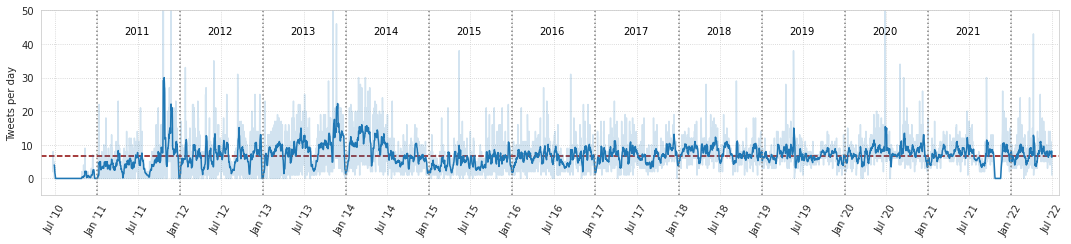

In [93]:
plot_volume(df, interactive=False,
            figsize=(15,3.5), 
            plot_smooth_only=False,
            exclude_entities=set(df.entity.unique().tolist()) - set(['EU_Commission']),
            ylim=True, freq='D', roll_window=7)

In [ ]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
for entity in set(df.entity.unique().tolist()) - set(['EU_Commission']):
    plot_volume(df, interactive=False,
                figsize=(10,3), 
                plot_smooth_only=False,
                exclude_entities=set(df.entity.unique().tolist()) - set(['EU_Commission', entity]),
                ylim=True, freq='D', roll_window=7,
                multiple=True, colors=['grey', 
                                       'indianred'], 
                savename=entity)

## Style

#### Qualitative style comparison

In [70]:
df['n_mentions'] = df['text'].replace('[^@]','', regex=True).str.len()
df['n_hashtag'] = df['text'].replace('[^#]','', regex=True).str.len()
for c in ['n_hashtag', 'n_mentions', 'n_emojis']:
    df[c] = df[c] / df['benoit_sentence-length-words']

In [71]:
df['year'] = df['created_at'].apply(lambda x: x.year)
df['month'] = df['created_at'].apply(lambda x: x.month)

In [72]:
readability_add = ['gunning_fog',
                   'automated_readability_index',
                   'coleman_liau_index',
                   'lix',
                   'rix']
length_add = ['n_characters', 'n_sentences']
style_targets = [c for c in df.columns if any(['rauh' in c, 
                                               'benoit' in c, 
                                               'alpha_ratio' in c])] + \
                ['n_hashtag', 'n_mentions', 'is_link', 'n_emojis'] + \
                readability_add + length_add
sentiment_targets = [c for c in df.columns if 'sentiment' in c]


In [73]:
new_names = ['% alphanumeric', 
             'frequency',
             'verb-to-noun ratio', 
             'Flesch-Kincaid Grade',
             'Flesch reading ease',
             '# words', 
             'sentence length (words)', 
             'sentence length (chars)', 
             'word length (syllables)',
             'word length (chars)', 
             '% nouns', 
             '% hashtag', '% mentions', 
             'has link', '% emojis',
             'Gunning Fog', 'Automated Readability Index', 'Coleman-Liau Index', 
             'LIX', 'RIX', '# characters', '# sentences',
             'negative sentiment', 'neutral sentiment', 'positive sentiment']

In [74]:
df_standard = df.copy()
#for c in style_targets:
#    df_standard[c] = (df_standard[c] - df_standard[c].mean()) / df_standard[c].std()
df_standard = df_standard.rename(dict(zip(style_targets+sentiment_targets,
                                          new_names)), axis=1)

### Within EU Commission, over time

In [75]:
df_reduced = df_standard.copy()
df_reduced = df_reduced.dropna(subset=new_names)
df_reduced = df_reduced.drop(['% nouns'], axis=1)

164299


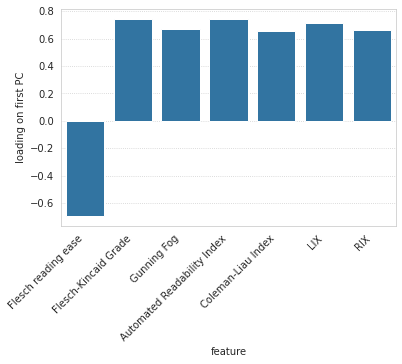

[8.11451636e-01 8.03535087e-02 6.34911948e-02 2.14844986e-02
 1.44451201e-02 8.20085390e-03 5.73188045e-04]
164299


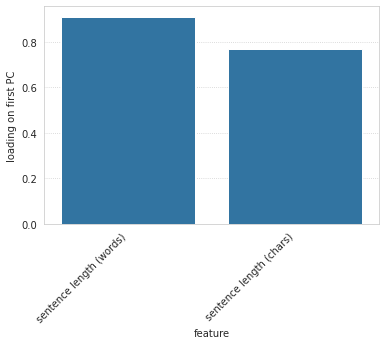

[0.96543171 0.03456829]
164299


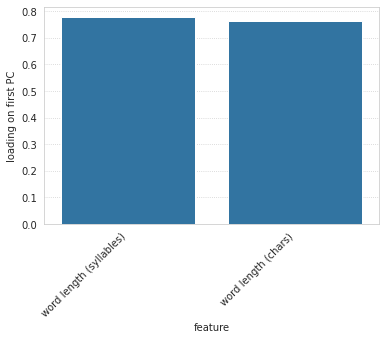

[0.92219203 0.07780797]
164299


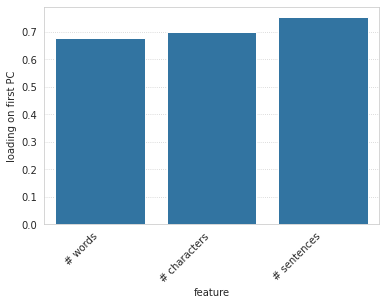

[0.77832121 0.20659981 0.01507899]


In [76]:
import numpy as np
from sklearn.decomposition import PCA
reduce_sets = [['Flesch reading ease',
                'Flesch-Kincaid Grade',
                'Gunning Fog', 'Automated Readability Index', 
                'Coleman-Liau Index', 
                'LIX', 'RIX'],
               ['sentence length (words)',
                'sentence length (chars)'],
               ['word length (syllables)',
                'word length (chars)'],
               ['# words', '# characters', '# sentences',]]
new_names = ['reading complexity', 'sentence length', 'word length', 'tweet length']

for rs, nn in zip(reduce_sets, new_names):
    X = df_reduced[rs].dropna()
    X = RobustScaler().fit_transform(X) 
    print(X.shape[0])
    pca = PCA(n_components=len(rs))
    pca.fit(X)
    df_reduced[nn] = pca.transform(X)[:,0]
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loading_matrix = pd.DataFrame(loadings, columns=[f'PC{i}' 
                                                     for i in range(len(rs))], index=rs)
    loading_matrix = loading_matrix.reset_index().melt(id_vars='index')
    sns.barplot(data=loading_matrix[loading_matrix['variable']=='PC0'], 
                x='index', y='value', color=sns.color_palette()[0])
    plt.xlabel('feature')
    plt.ylabel('loading on first PC')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    print(pca.explained_variance_ratio_)

In [77]:
new_cols = ['concreteness',
            'reading complexity',
            'verb-to-noun ratio',
            'tweet length',
            'sentence length',
            'word length',
            'frequency',
            'negative sentiment', 'neutral sentiment', 'positive sentiment',
            '% hashtag', '% mentions', 
            '% emojis']

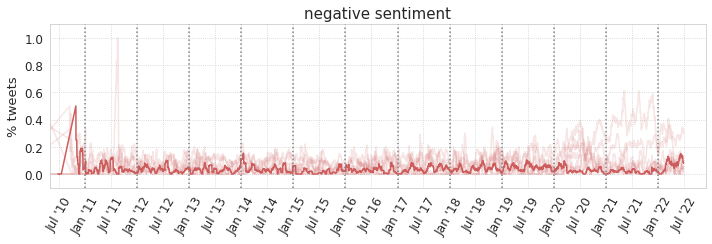

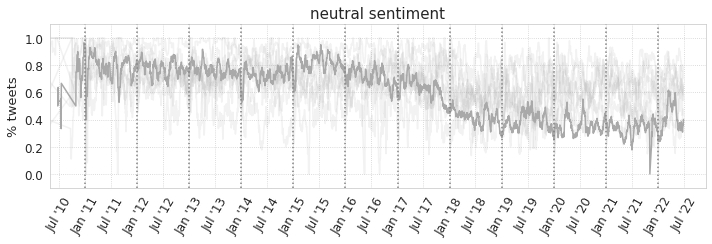

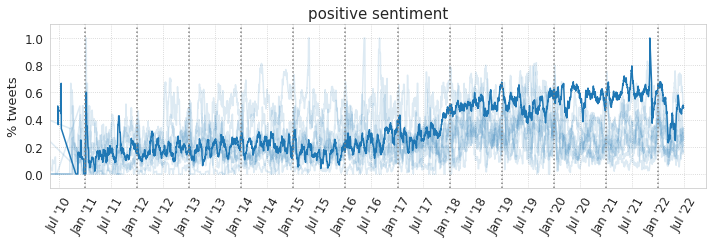

In [91]:
for c in [n for n in new_cols if 'sentiment' in n]:
    if 'positive' in c:
        color = sns.color_palette()[0]
    elif 'neutral' in c:
        color = 'darkgrey'
    else:
        color = 'indianred'
    plot_style_timeseries(df_reduced, 
                          entities=df_reduced.entity.unique(), #[e,'EU_Commission'],
                          colors=[color] * 9,
                          metric=c,
                          freq='D', 
                          roll_window=21,
                          normalized=False,
                          savename=f'sentiment_timeseries/{c}',
                          interactive=False,
                          title=f'{c}',
                          no_horizontal=True,
                          ylim=(-0.1,1.1),
                          figsize=(10,3.5), 
                          plot_smooth_only=True, 
                          legend=False)

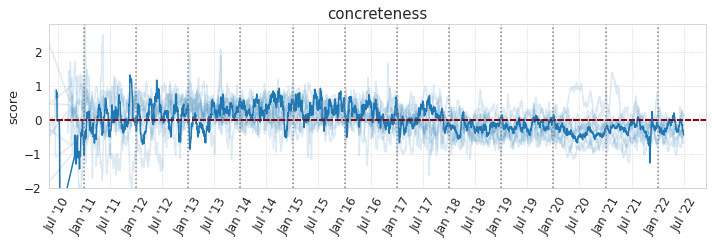

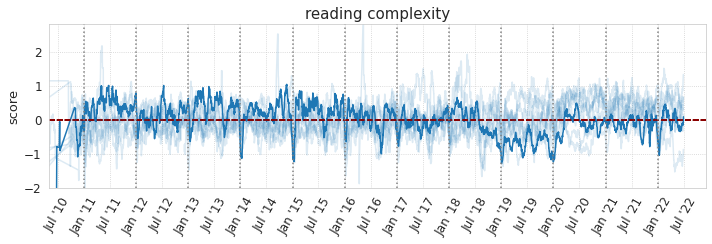

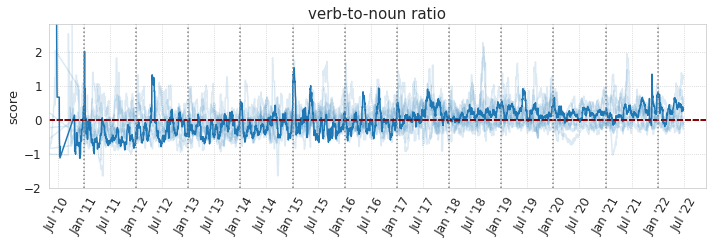

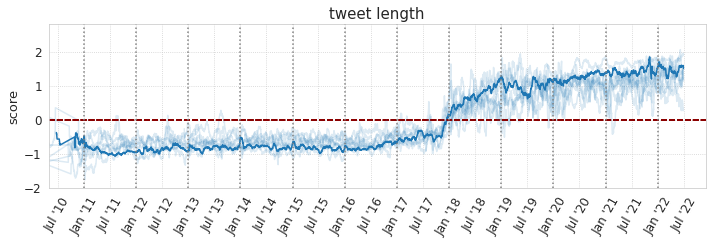

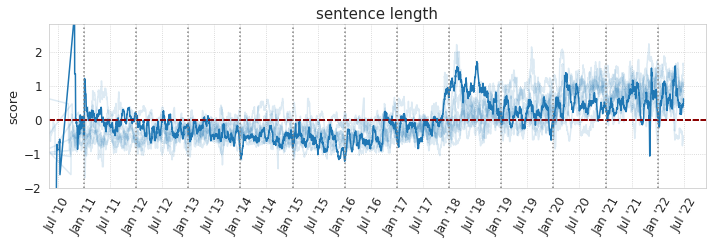

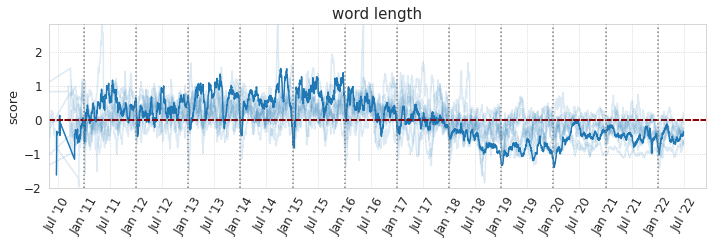

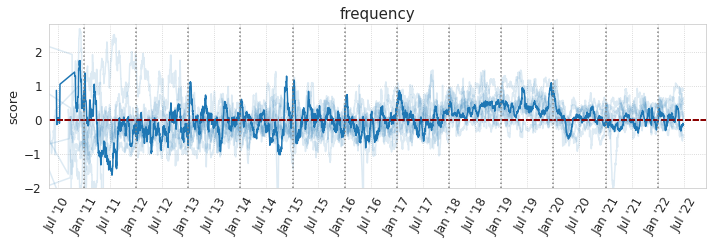

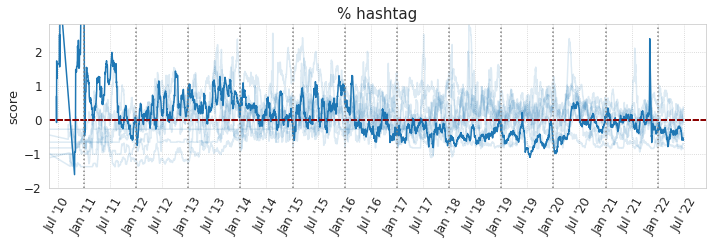

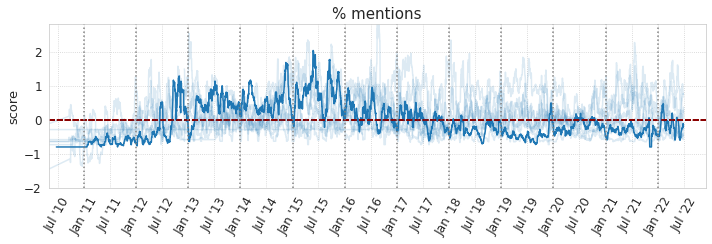

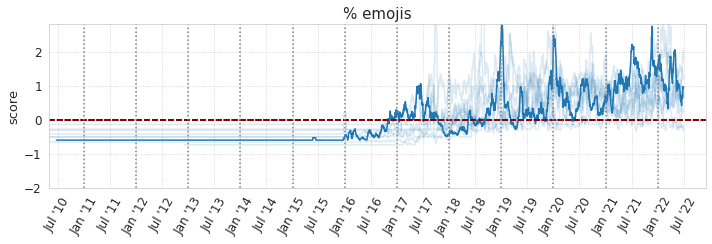

In [90]:
for i, c in enumerate(new_cols):
    if 'sentiment' not in c:
        plot_style_timeseries(df_reduced, 
                              entities=df_reduced.entity.unique(),
                              colors = [sns.color_palette()[0]] * 9,
                              metric=c,
                              freq='D', 
                              roll_window=21,
                              normalized=True,
                              savename=f'style_timeseries/{c}',
                              plot_smooth_only=True,
                              interactive=False,
                              no_horizontal='mean',
                              ylim=(-2,2.8),
                              figsize=(10,3.5),
                              legend=False)

### Qualitative comparison

In [80]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

coffs = range(2014,2023)

ests = []
for coff in coffs:
    for t in new_cols:
        # print(t)
        scaler = RobustScaler()
        new_t_name = t.replace('-','_')
        new_t_name = new_t_name.replace(' ','_')
        new_t_name = new_t_name.replace('#','n')
        new_t_name = new_t_name.replace('%','prop')
        data = df_reduced[df_reduced['year']==coff].rename({t: new_t_name}, axis=1).fillna(0)
        data[new_t_name] = scaler.fit_transform(data[[new_t_name]])
        formula = f"{new_t_name} ~ C(entity, Treatment(reference='EU_Commission'))" #  + {' + '.join(topic_col)}" # added topics for control

        # Specify model
        mod = smf.rlm(formula, data=data, M=sm.robust.norms.HuberT()) # rlm

        # Freq workflow
        res = mod.fit()

        # Save estimates
        est_df = pd.DataFrame(res.params, columns=['param'])
        est_df['predictor'] = est_df.index.str.replace(r"C\(entity, Treatment\(reference='EU_Commission'\)\)\[T\.", "", 
                                                       regex=True)
        est_df['predictor'] = est_df['predictor'].str.replace(r"\]", "", regex=True)
        est_df['target'] = t
        est_df['p_val'] = res.pvalues.values
        est_df = est_df[~est_df['predictor'].isin(topic_col)]
        est_df = est_df.reset_index(drop=True)
        est_df = est_df[est_df['predictor']!='Intercept']
        est_df['year'] = coff
        ests.append(est_df)



invalid value encountered in true_divide
Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
overflow encountered in square
invalid value encountered in multiply


In [85]:
exclude = ['dominance', 'affect',
           'valence', 'has link',
           'has_link']
categories = {'Concreteness': ['concreteness'], 
              'Reading Complexity': ['reading complexity'],
              'Action-orientedness': ['verb-to-noun ratio'], 
              'Overall Length': ['tweet length'],
              'Sentence Length': ['sentence length'],
              'Lexical Complexity': ['word length', 'frequency'],
              'Twitter-specific Features': ['% hashtag', 
                                            '% mentions', 
                                            '% emojis'],
              'Sentiment': ['negative sentiment', 
                            'positive sentiment', 
                            'neutral sentiment']}

In [ ]:
ests = pd.concat(ests)
ests['param'] = ests['param'] * (ests['p_val']<0.05).astype(int)
ests.drop('p_val', axis=1, inplace=True)

ests = ests[~ests['target'].isin(exclude)]

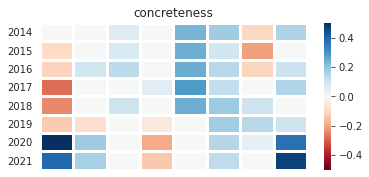

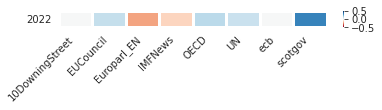

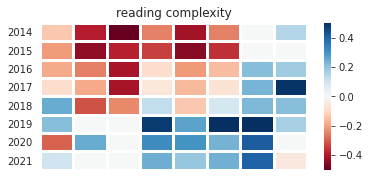

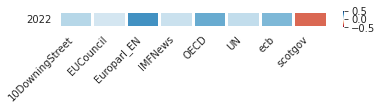

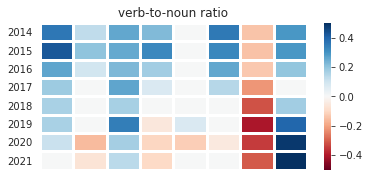

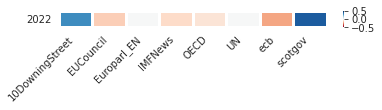

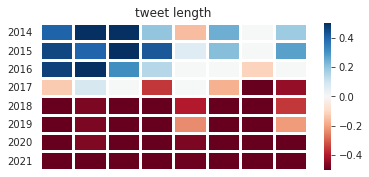

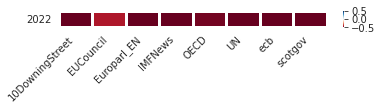

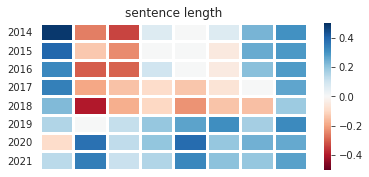

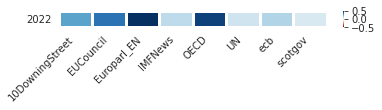

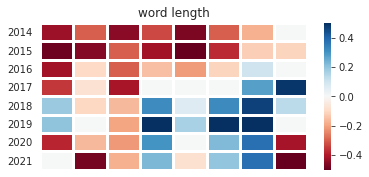

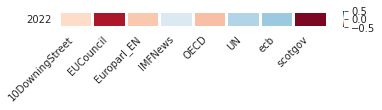

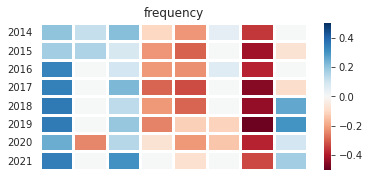

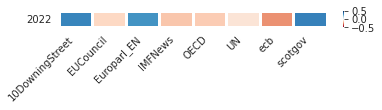

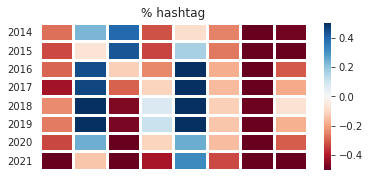

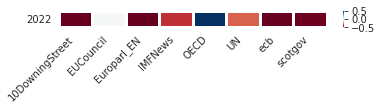

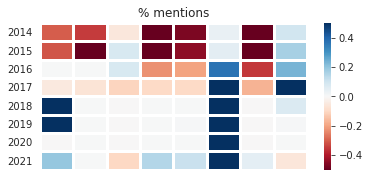

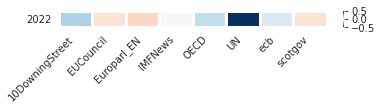

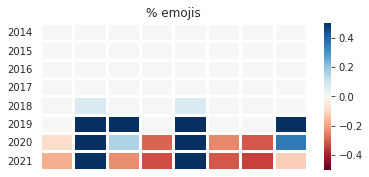

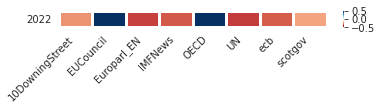

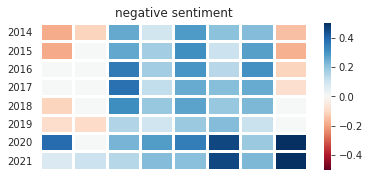

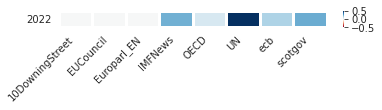

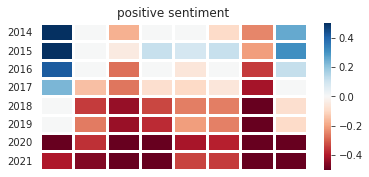

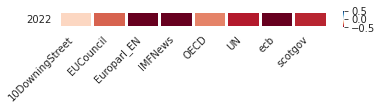

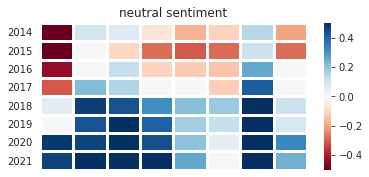

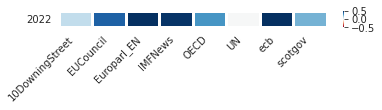

In [87]:
for k,v in categories.items():
    for vv in v:
        sub_grouped = ests[ests['target']==vv].drop('target', axis=1)
        sub_grouped = sub_grouped.pivot(index='predictor', columns='year').T # ests_wide.[[vv]].sort_values(by=vv).T
        sub_grouped.index = sub_grouped.index.get_level_values(1)
        plt.subplots(figsize=(6,0.3 * sub_grouped.shape[0]))
        ax = sns.heatmap(sub_grouped.iloc[:-1,:], cmap='RdBu', center=.0, 
                         linewidth=3, vmin=-.5, vmax=.5)
        plt.ylabel('')
        plt.xlabel('')
        plt.xticks(ticks=[], labels=[])
        plt.title(vv)
        plt.savefig(f'figs/heatmaps/{vv}_2021.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        plt.subplots(figsize=(6,0.3))
        ax = sns.heatmap(sub_grouped.iloc[-1:,:], cmap='RdBu', center=.0, 
                         linewidth=3, vmin=-.5, vmax=.5)
        plt.ylabel('')
        plt.xlabel('')
        plt.yticks(rotation=0)
        plt.xticks(labels=None, rotation=45, ha='right')
        plt.title('')
        plt.savefig(f'figs/heatmaps/{vv}_2022.png', dpi=300, bbox_inches='tight')
        plt.show()

In [60]:
df_reduced['date'] = pd.to_datetime(df_reduced[['year', 'month']].assign(day=1)).dt.strftime('%b \'%y')
vals = pd.to_datetime(df_reduced[['year', 'month']].assign(day=1)).sort_values().dt.strftime('%b \'%y').unique()
dct = dict(zip(vals, range(vals.shape[0])))
df_reduced['date_mapped'] = df_reduced['date'].replace(dct)

In [89]:
df_reduced.to_json('data/topic/data_renamed_reduced.jsonl', orient='records', lines=True)


### Results of predictive models

In [43]:
d = json.load(open('logs/engagement/sum_count.json'))

In [44]:
tr_res = pd.DataFrame(d).sort_values(by='test_r2')
tr_res['model'] = tr_res['model'].str.replace('sum_count_', '')

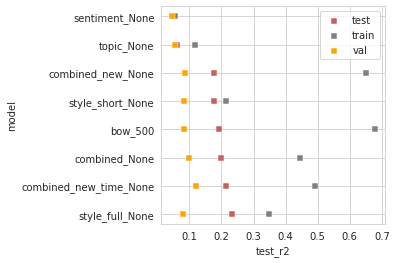

In [45]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(data=tr_res, x='test_r2', y='model', label='test', color='indianred', marker='s')
sns.scatterplot(data=tr_res, x='train_r2', y='model', label='train', color='grey', marker='s')
sns.scatterplot(data=tr_res, x='val_r2', y='model', label='val', color='orange', marker='s')
plt.show()

In [46]:
dfs = []
for metric in ['sum']:
    fs = glob.glob(f'logs/engagement/{metric}_count/pred*.pkl')
    for f in fs:
        f_df = pd.read_pickle(f)
        f_df['metric'] = metric
        dfs.append(f_df)
    metrics = pd.concat(dfs, ignore_index=True)
    

logs/engagement/sum_count/pred_sum_count_topic_None_train.pkl
logs/engagement/sum_count/pred_sum_count_style_short_None_train.pkl
logs/engagement/sum_count/pred_sum_count_sentiment_None_test.pkl
logs/engagement/sum_count/pred_sum_count_topic_None_val.pkl
logs/engagement/sum_count/pred_sum_count_bow_500_test.pkl
logs/engagement/sum_count/pred_sum_count_sentiment_None_val.pkl
logs/engagement/sum_count/pred_sum_count_style_short_None_val.pkl
logs/engagement/sum_count/pred_sum_count_combined_None_test.pkl
logs/engagement/sum_count/pred_sum_count_combined_None_train.pkl
logs/engagement/sum_count/pred_sum_count_combined_new_None_train.pkl
logs/engagement/sum_count/pred_sum_count_combined_new_time_None_test.pkl
logs/engagement/sum_count/pred_sum_count_bow_500_train.pkl
logs/engagement/sum_count/pred_sum_count_style_short_None_test.pkl
logs/engagement/sum_count/pred_sum_count_combined_new_time_None_val.pkl
logs/engagement/sum_count/pred_sum_count_combined_new_None_test.pkl
logs/engagement/sum_

In [47]:
spears = metrics.groupby(['metric', 'split',
                          'model_name'])[['label', 
                                          'prediction']].apply(lambda x: x.corr('spearman').iloc[0,1]).reset_index()
spears = spears.rename({0: 'spearman_cor'}, axis=1)

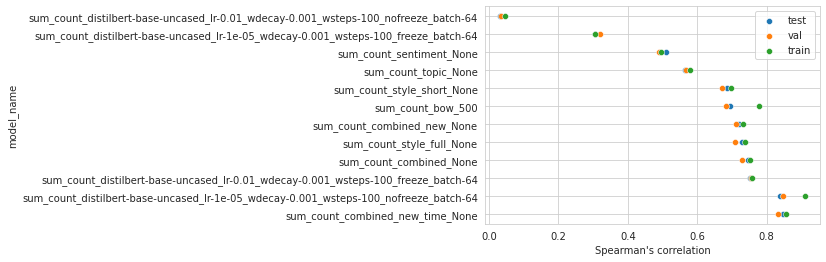

In [49]:
for metric in ['sum']:
    for out_metric in ['spearman_cor']:
        spears = spears.sort_values(by=out_metric, ascending=True)
        for split in ['test',  'val', 'train']:
            sns.scatterplot(data=spears[(spears['split']==split) & \
                                        (spears['metric']==metric)],
                            y='model_name', x='spearman_cor', label=split)
        plt.xlabel('Spearman\'s correlation')
        plt.show()

### Predictive models

In [338]:
with xgboost.config_context(verbosity=0):
    for metric in ['sum']:
        fnames = glob.glob(f'logs/engagement/{metric}_count/{metric}_count_*.pkl')
        for m in [f for f in fnames if 'combined_new' in f and 'time' not in f]: # combined
            name = m.split('/')[-1]
            model = pkl.load(open(m, 'rb'))
            print(m)
            feature_names = new_topic_col + new_style_col # + ['date_mapped']
            df = pd.DataFrame(zip(model.feature_importances_,
                                  feature_names), 
                              columns=['importance', 'feature'])
            df = df.sort_values(by='importance')
            shaps = pkl.load(open(f'logs/engagement/{metric}_count/shap_{name}','rb'))
            shaps.feature_names = feature_names
    

logs/engagement/sum_count/sum_count_combined_new_None.pkl


In [339]:
from src.colnames import new_topic_col, new_style_col

In [340]:
shaps_df = pd.DataFrame(shaps.values.T)
shaps_df['feature_name'] = feature_names
shaps_long = shaps_df.melt(id_vars='feature_name')
norm_data = RobustScaler().fit_transform(shaps.data)
shaps_df_data = pd.DataFrame(norm_data.T)
shaps_df_data['feature_name'] = feature_names
shaps_long_data = shaps_df_data.melt(id_vars='feature_name')
shaps_long['data'] = shaps_long_data['value']
shaps_long['data_simple'] = np.select([(shaps_long['data']<0), 
                                       (shaps_long['data']==0), 
                                       (shaps_long['data']>0)], 
                                      ['low', 0, 'high'])

In [341]:
sort_shaps = shaps_long.groupby('feature_name')['value'].agg(lambda x: x.abs().mean()).reset_index().sort_values('value',
                                                                                                                 ascending=False)

Text(0.5, 1.0, 'Style features')

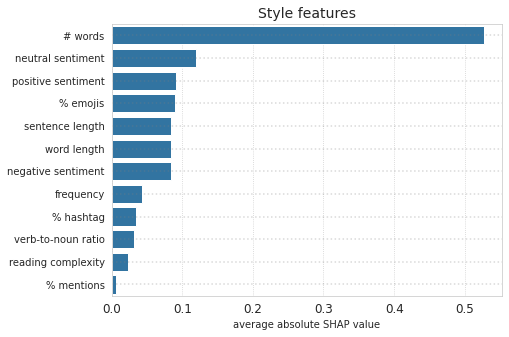

In [342]:
plt.subplots(figsize=(7,5))
for i in range(len(new_style_col)):
    plt.axhline(i, linestyle='dotted', alpha=.3, color='grey')
sns.barplot(data=sort_shaps[sort_shaps['feature_name'].isin(new_style_col)],
            x='value', y='feature_name', color=sns.color_palette()[0])
plt.xlabel('average absolute SHAP value')
plt.ylabel('')
plt.xticks(fontsize=12)
plt.title('Style features', fontsize=14)

Text(0.5, 1.0, 'Topics')

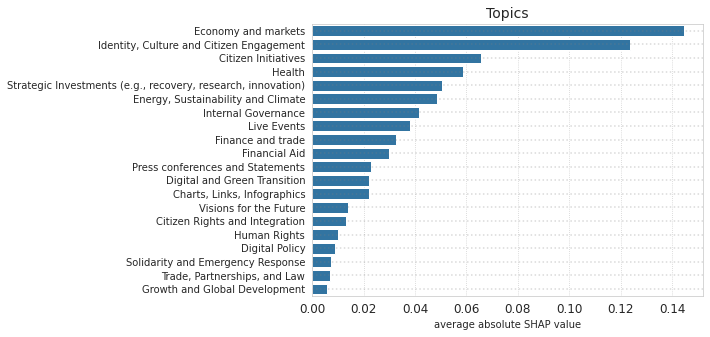

In [343]:
plt.subplots(figsize=(7,5))
for i in range(len(new_topic_col)):
    plt.axhline(i, linestyle='dotted', alpha=.3, color='grey')
sns.barplot(data=sort_shaps[sort_shaps['feature_name'].isin(new_topic_col)],
            x='value', y='feature_name', color=sns.color_palette()[0])
plt.xlabel('average absolute SHAP value')
plt.ylabel('')
plt.xticks(fontsize=12)
plt.title('Topics', fontsize=14)

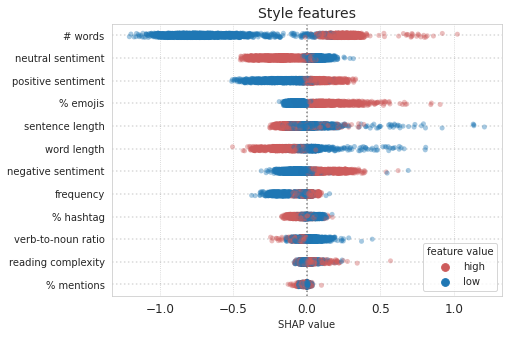

In [344]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
plt.subplots(figsize=(7,5))
data = shaps_long[shaps_long['feature_name'].isin(new_style_col)]
data = data.merge(sort_shaps, on='feature_name').sort_values(by='value_y', ascending=False)
for i in range(len(new_style_col)):
    plt.axhline(i, linestyle='dotted', alpha=.3, color='grey')
plt.axvline(0, color='grey', linestyle='dotted')
sns.stripplot(data=data,
             y='feature_name', x='value_x', 
                hue='data_simple', palette=['indianred', 
                                            sns.color_palette()[0]],
                hue_order=['high', 'low'],
                alpha=.4)
plt.legend(title='feature value', loc='lower right')
plt.ylabel('')
plt.xlabel('SHAP value')
plt.xticks(fontsize=12)
plt.title('Style features', fontsize=14)
plt.show()

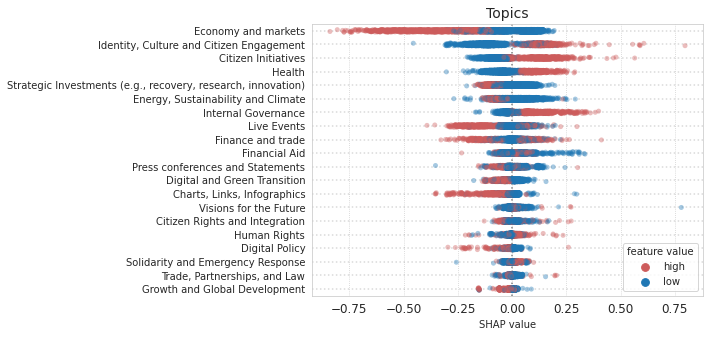

In [345]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
plt.subplots(figsize=(7,5))
data = shaps_long[shaps_long['feature_name'].isin(new_topic_col)]
data = data.merge(sort_shaps, on='feature_name').sort_values(by='value_y', ascending=False)
for i in range(len(new_topic_col)):
    plt.axhline(i, linestyle='dotted', alpha=.3, color='grey')
plt.axvline(0, color='grey', linestyle='dotted')
sns.stripplot(data=data,
             y='feature_name', x='value_x', 
                hue='data_simple', palette=['indianred', 
                                            sns.color_palette()[0]],
                alpha=.4)
plt.legend(title='feature value', loc='lower right')
plt.ylabel('')
plt.xlabel('SHAP value')
plt.xticks(fontsize=12)
plt.title('Topics', fontsize=14)
plt.show()